# DAML 10 - Neural Networks

Michal Grochmal <michal.grochmal@city.ac.uk>

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
from sklearn.datasets import fetch_lfw_people
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

## Glass Dataset

The forensics of glass composition can reveal the provenience of a piece of glass,
yet different brands of glass are slightly different from each other.
We will build a model which will classify glass based on its composition,
and will use online learning so that we are ready to learn from new data at any time.

We now build our `load_glass` function.

In [3]:
import os
import sys
import requests
import numpy as np
from sklearn import datasets
from sklearn.utils import Bunch


def load_glass():
    glass_dir = 'uci_glass'
    data_dir = datasets.get_data_home()
    data_path = os.path.join(data_dir, glass_dir, 'glass.data')
    descr_path = os.path.join(data_dir, glass_dir, 'glass.names')
    glass_data = 'https://archive.ics.uci.edu/ml/machine-learning-databases/glass/glass.data'
    glass_descr = 'https://archive.ics.uci.edu/ml/machine-learning-databases/glass/glass.names'
    os.makedirs(os.path.join(data_dir, glass_dir), exist_ok=True)
    try:
        with open(descr_path, 'r') as f:
            descr = f.read()
    except IOError:
        print('Downloading file from', glass_descr, file=sys.stderr)
        r = requests.get(glass_descr)
        with open(descr_path, 'w') as f:
            f.write(r.text)
        descr = r.text
        r.close()
    try:
        data = np.loadtxt(data_path, delimiter=',')
    except IOError:
        print('Downloading file from', glass_data, file=sys.stderr)
        r = requests.get(glass_data)
        with open(data_path, 'w') as f:
            f.write(r.text)
        r.close()
        data = np.loadtxt(data_path, delimiter=',')
    target = data[:, 10].astype(np.int).copy()
    target[target > 3] -= 1  # fix non-existent classes
    return Bunch(DESCR=descr,
                 data=data[:, :10].copy(),
                 feature_names=['ID', 'RI', 'Na', 'Mg', 'Al', 'Si', 'K', 'Ca', 'Ba', 'Fe'],
                 target=target,
                 target_names=['windows_float_processed',
                               'windows_non_float_processed',
                               'vehicle_windows',
                               'containers',
                               'tableware',
                               'headlamps'])


glass = load_glass()
print(glass.DESCR)

1. Title: Glass Identification Database

2. Sources:
    (a) Creator: B. German
        -- Central Research Establishment
           Home Office Forensic Science Service
           Aldermaston, Reading, Berkshire RG7 4PN
    (b) Donor: Vina Spiehler, Ph.D., DABFT
               Diagnostic Products Corporation
               (213) 776-0180 (ext 3014)
    (c) Date: September, 1987

3. Past Usage:
    -- Rule Induction in Forensic Science
       -- Ian W. Evett and Ernest J. Spiehler
       -- Central Research Establishment
          Home Office Forensic Science Service
          Aldermaston, Reading, Berkshire RG7 4PN
       -- Unknown technical note number (sorry, not listed here)
       -- General Results: nearest neighbor held its own with respect to the
             rule-based system

4. Relevant Information:n
      Vina conducted a comparison test of her rule-based system, BEAGLE, the
      nearest-neighbor algorithm, and discriminant analysis.  BEAGLE is 
      a product available 

In [4]:
pd.Series(glass.target).value_counts()

2    76
1    70
6    29
3    17
4    13
5     9
dtype: int64

Without knowing much about this model, let's try to use a neural network
to classify this dataset.  We know that the neural network is a good amount
of interconnected perceptrons and that we perturb the perceptron weights
based on errors in classification to achieve convergence.

We also know that `sklearn` provides us with a simple neural network class,
no harm in trying it out.

In [5]:
xtrain, xtest, ytrain, ytest = train_test_split(glass.data, glass.target, test_size=0.2, random_state=42)

In [6]:
net = MLPClassifier(activation='relu', hidden_layer_sizes=(20,), alpha=0.01, tol=0.001,
                    max_iter=200, solver='sgd', learning_rate='constant')
param_dict = {
    'alpha': [0.0001, 0.001, 0.01, 0.1, 1.0],
    'tol': [0.001, 0.01, 0.1],
}
grid = GridSearchCV(net, param_dict, cv=9)
grid.fit(xtrain, ytrain)
grid.best_estimator_

/home/grochmal/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 6 members, which is too few. The minimum number of members in any class cannot be less than n_splits=9.
  % (min_groups, self.n_splits)), Warning)


MLPClassifier(activation='relu', alpha=0.1, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(20,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='sgd', tol=0.01, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [7]:
grid.best_score_

0.80116959064327486

In [8]:
yfit = grid.best_estimator_.predict(xtest)
print(classification_report(ytest, yfit, target_names=glass.target_names))

                             precision    recall  f1-score   support

    windows_float_processed       1.00      0.91      0.95        11
windows_non_float_processed       0.82      1.00      0.90        14
            vehicle_windows       0.50      0.33      0.40         3
                 containers       0.00      0.00      0.00         4
                  tableware       0.00      0.00      0.00         3
                  headlamps       0.57      1.00      0.73         8

                avg / total       0.67      0.77      0.70        43



/home/grochmal/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


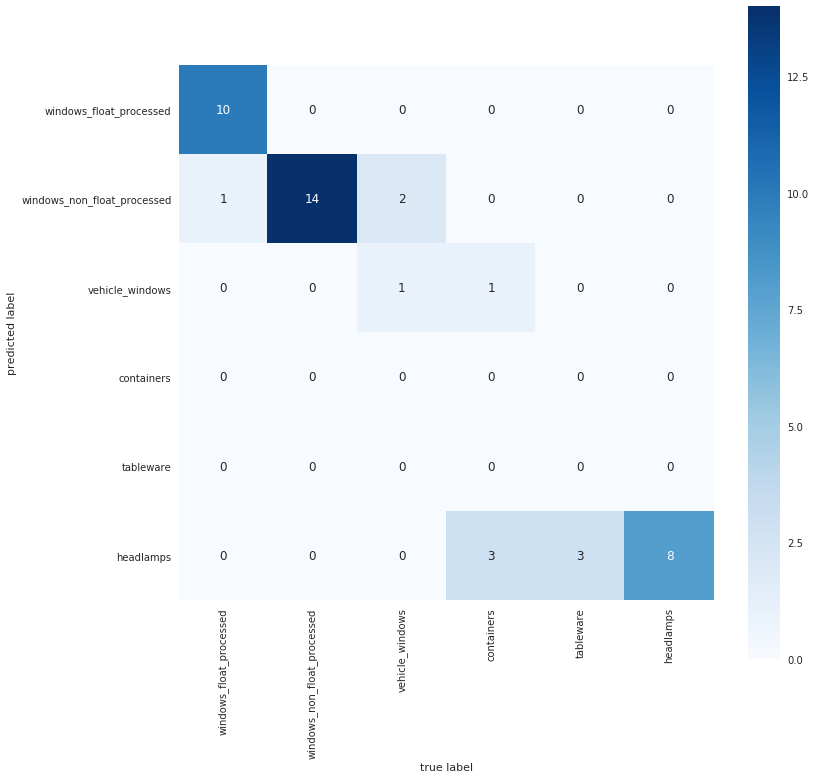

In [9]:
m = confusion_matrix(ytest, yfit)
fig = plt.figure(figsize=(12, 12))
ax = sns.heatmap(m.T, square=True, annot=True, fmt='d', cmap='Blues',
                 xticklabels=glass.target_names, yticklabels=glass.target_names)
ax.set(xlabel='true label', ylabel='predicted label');

From the above we learned one of the most important details about neural networks:
since weights are updated based on classification errors between expected and predicted
classes, if we have classes with very little support the network will fail at classifying
them.

As we get collect more data the effect of classes with smaller support diminishes.
Neural Nets work in similar fashion to us, humans, you cannot show a person 2 paintings
by Titian and then 200 painting not by Titian and expect her to be an expert at identifying
Titian's work.  ANNs work best the more data and more diverse data you have.

For the glass data I'll leave as an exercise trying out a Random Forest,
that model is very good at digging out classes with small support
(but not decision trees!).  But for now let's understand more abot ANNs.

## Neural Network Concepts

OK, so how does that work?
We managed to train perceptrons because we knew what the output of each perceptron should be.
And we saw that a perceptron can only output either -1 or 1 with the `sign` function.

In neural networks the perceptrons are organized in layers:

- One *input layer* which has one perceptron per feature
- At least one *hidden layer* with fully connected perceptrons
- One output layer with one perceptron per output class (or just one for regression)

Each perceptron will have its own weights, and these will be trained simultaneously
across the entire network, by a process called *backpropagation*.
But before we dive into backpropagation let's discuss activation functions.
The `sign` function is only one viable activation function,
we can make our ANN work with several others:

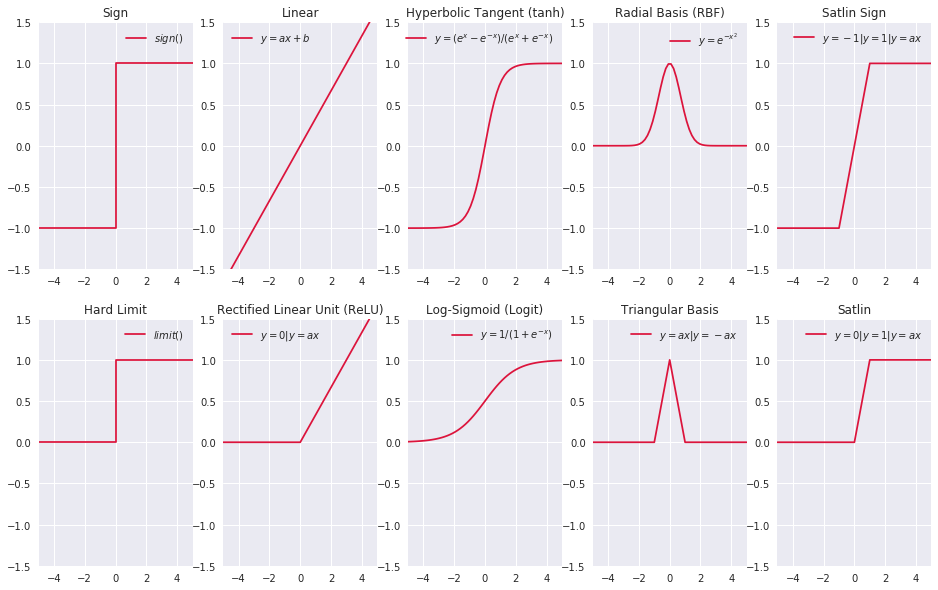

In [10]:
fig, ax = plt.subplots(2, 5, figsize=(16, 10))
ax_size = [-5, 5, -1.5, 1.5]
# sign
x_full = np.linspace(-5, 5, 60)
x1 = np.linspace(-5, 0, 30)
x2 = np.linspace(0, 5, 30)
y1 = x1*0 - 1
y2 = x2*0 + 1
ax[0, 0].plot(np.hstack([x1, x2]), np.hstack([y1, y2]), color='crimson')
ax[0, 0].legend(['$sign()$'])
ax[0, 0].axis(ax_size)
ax[0, 0].set_title('Sign')
# hard limit
y1 = x1*0
y2 = x2*0 + 1
ax[1, 0].plot(np.hstack([x1, x2]), np.hstack([y1, y2]), color='crimson')
ax[1, 0].legend(['$limit()$'])
ax[1, 0].axis(ax_size)
ax[1, 0].set_title('Hard Limit')
# linear
ax[0, 1].plot(x_full, x_full/3, color='crimson')
ax[0, 1].legend(['$y = ax + b$'])
ax[0, 1].axis(ax_size)
ax[0, 1].set_title('Linear')
# relu
y1 = x1*0
y2 = x2
ax[1, 1].plot(np.hstack([x1, x2]), np.hstack([y1, y2/3]), color='crimson')
ax[1, 1].legend(['$y = 0 | y = ax$'])
ax[1, 1].axis(ax_size)
ax[1, 1].set_title('Rectified Linear Unit (ReLU)')
# tanh sigmoid
y_full = (np.exp(x_full) - np.exp(-x_full))/(np.exp(x_full) + np.exp(-x_full))
ax[0, 2].plot(x_full, y_full, color='crimson')
ax[0, 2].legend(['$y = (e^{x} - e^{-x})/(e^{x} + e^{-x})$'])
ax[0, 2].axis(ax_size)
ax[0, 2].set_title('Hyperbolic Tangent (tanh)')
# log sigmoid
y_full = 1/(1 + np.exp(-x_full))
ax[1, 2].plot(x_full, y_full, color='crimson')
ax[1, 2].legend(['$y = 1/(1 + e^{-x})$'])
ax[1, 2].axis(ax_size)
ax[1, 2].set_title('Log-Sigmoid (Logit)')
# radial basis
y_full = np.exp(- x_full*x_full)
ax[0, 3].plot(x_full, y_full, color='crimson')
ax[0, 3].legend(['$y = e^{-x^2}$'])
ax[0, 3].axis(ax_size)
ax[0, 3].set_title('Radial Basis (RBF)')
# triangular basis
x1 = np.linspace(-5, -1, 30)
x2 = np.linspace(-1, 0, 10)
x3 = np.linspace(0, 1, 10)
x4 = np.linspace(1, 5, 30)
y1 = x1*0
y2 = x2 + 1
y3 = 1 - x3
y4 = x4*0
ax[1, 3].plot(np.hstack([x1, x2, x3, x4]), np.hstack([y1, y2, y3, y4]), color='crimson')
ax[1, 3].legend(['$y = ax | y = -ax$'])
ax[1, 3].axis(ax_size)
ax[1, 3].set_title('Triangular Basis')
# satlin sign
x1 = np.linspace(-5, -1, 30)
x2 = np.linspace(-1, 0, 10)
x3 = np.linspace(0, 1, 10)
x4 = np.linspace(1, 5, 30)
y1 = x1*0 - 1
y2 = x2
y3 = x3
y4 = x4*0 + 1
ax[0, 4].plot(np.hstack([x1, x2, x3, x4]), np.hstack([y1, y2, y3, y4]), color='crimson')
ax[0, 4].legend(['$y = -1 | y = 1 | y = ax$'])
ax[0, 4].axis(ax_size)
ax[0, 4].set_title('Satlin Sign')
# satlin
x1 = np.linspace(-5, -1, 30)
x2 = np.linspace(-1, 0, 10)
x3 = np.linspace(0, 1, 10)
x4 = np.linspace(1, 5, 30)
y1 = x1*0
y2 = x2*0
y3 = x3
y4 = x4*0 + 1
ax[1, 4].plot(np.hstack([x1, x2, x3, x4]), np.hstack([y1, y2, y3, y4]), color='crimson')
ax[1, 4].legend(['$y = 0 | y = 1 | y = ax$'])
ax[1, 4].axis(ax_size)
ax[1, 4].set_title('Satlin');

And that's not all, for the last layer of the network two other functions are often used.
The `compet` function, which outputs a unit value for the maximum input and zeros for
all other inputs.

$$\text{compet} = floor \left( \frac{x_i}{max(x)} \right), \text{for i in }1, 2, \dots, N$$

And the `softmax` functions which scales all inputs so that the sum of all inputs equals a unit.

$$\text{softmax} = \frac{e^{x_i}}{\sum_{k = 0}^{N} e^{x_k}} , \text{for i in }1, 2, \dots, N$$

## Backpropagation

How can we train the perceptrons in the hidden layer?
We do not really know what their output should be.
We can certainly say that we have all weights in a vector, let's call is $w$,
and then we can attempt Gradient Descent to find the best matrix.
But GD requires us to have some form of cost (error) function since it is defined as:

$$
\nabla E = \frac{\partial E}{\partial p_1}\hat{\imath} + \frac{\partial E}{\partial p_2}\hat{\jmath} + \ldots
$$

The cost function will be multidimensional, exactly one dimension per weight
in the vector $w$.  And the total error of the network will be a sum of the
error contribution of each weight (say vectro $e$):

$$E = \sum a(w^T \cdot e)$$

Where $a$ is the activation function.

If we know the contribution of error from each weight, we can derivate this function
above and we have all the components of the error vector to perform gradient descent.
Simplifying the problem:
If we know the classification error of one output perceptron and we know its weights,
we can divide it across the weights coming into the perceptron, and then multiply
by the weights to get each weight contribution.  The contribution of each weight
coming into the output perceptron is the contribution of the output of the perceptron
in the previous layer.  Summing up the output contributions in the previous layer
we know the error contributions on the output side of each perceprtron on that layer.
We can then repeat for this layer, and also get the contributions of the output of
the previous layer.  And so on.

In the end we have the error contribution of every weight, which, when applied the
derivate of the activation function, is one of the components of the Error Gradient
vector.  And going in the opposite direction of the error gradient vector we are
minimizing the error of the function, and therefore making the network classify better!

## Faces

The previous more-or-less real problem we faced was face identification with
the LFW dataset.  This is a quite complex dataset but has a good number of instances.
A neural network has a chance of performing a good-enough classification.

In [11]:
faces = fetch_lfw_people(min_faces_per_person=50)
faces.DESCR

'LFW faces dataset'

In [12]:
pca = PCA(n_components=200)
faces_pca = pca.fit_transform(faces.data)
xtrain, xtest, ytrain, ytest = train_test_split(faces_pca, faces.target, test_size=0.2)

In [13]:
net = MLPClassifier(hidden_layer_sizes=(300,), alpha=0.001, tol=0.01,
                    max_iter=100, solver='sgd', learning_rate='constant')
param_dict = {
    'alpha': [0.001, 0.01, 0.1, 1.0],
    'tol': [0.001, 0.01],
}
grid = GridSearchCV(net, param_dict, cv=5)
grid.fit(xtrain, ytrain)
grid.best_estimator_

MLPClassifier(activation='relu', alpha=1.0, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(300,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=100, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='sgd', tol=0.001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [14]:
grid.best_score_

0.72275641025641024

In [15]:
yfit = grid.predict(xtest)
print(classification_report(ytest, yfit, target_names=faces.target_names))

                   precision    recall  f1-score   support

     Ariel Sharon       0.75      0.86      0.80        14
     Colin Powell       0.83      0.76      0.79        45
  Donald Rumsfeld       0.77      0.63      0.69        27
    George W Bush       0.74      0.94      0.83       101
Gerhard Schroeder       0.76      0.64      0.70        25
      Hugo Chavez       0.67      0.67      0.67        12
   Jacques Chirac       0.75      0.25      0.38        12
    Jean Chretien       0.85      1.00      0.92        11
    John Ashcroft       0.80      0.73      0.76        11
Junichiro Koizumi       0.88      0.78      0.82        18
  Serena Williams       1.00      0.71      0.83        14
       Tony Blair       0.72      0.59      0.65        22

      avg / total       0.78      0.77      0.76       312



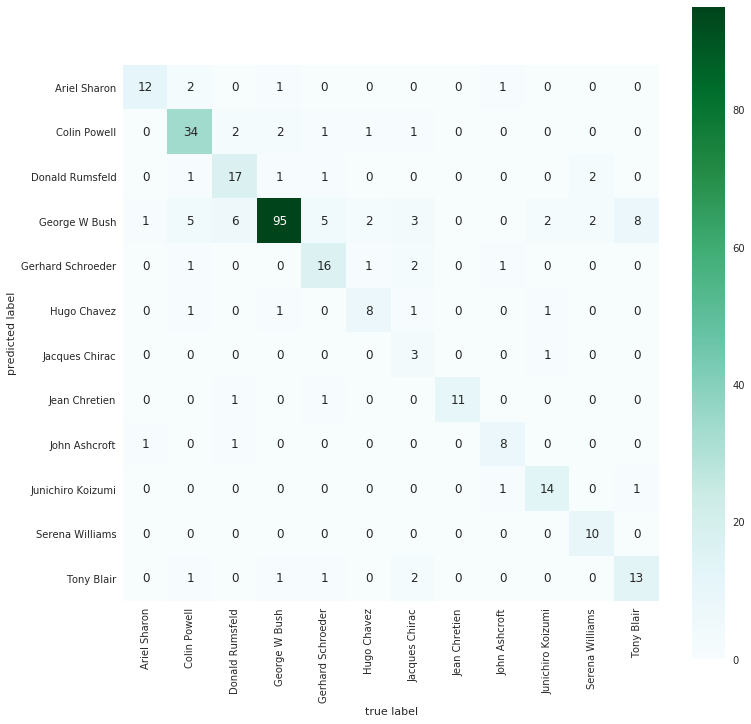

In [16]:
m = confusion_matrix(ytest, yfit)
fig = plt.figure(figsize=(12, 12))
ax = sns.heatmap(m.T, square=True, annot=True, fmt='d', cmap='BuGn',
                 xticklabels=faces.target_names, yticklabels=faces.target_names)
ax.set(xlabel='true label', ylabel='predicted label');

In [17]:
sizes = [10, 30, 60, 100, 200, 300, 600, 900]
scores1 = []
scores2 = []
for size in sizes:
    for s in [scores1, scores2]:
        print('Trianing net of size', size)
        net = MLPClassifier(hidden_layer_sizes=(size,),
                            alpha=0.001, max_iter=100, solver='sgd')
        net.fit(xtrain, ytrain)
        score = net.score(xtest, ytest)
        s.append(score)

Trianing net of size 10
Trianing net of size 10
Trianing net of size 30
Trianing net of size 30
Trianing net of size 60
Trianing net of size 60
Trianing net of size 100
Trianing net of size 100
Trianing net of size 200
Trianing net of size 200
Trianing net of size 300
Trianing net of size 300
Trianing net of size 600
Trianing net of size 600
Trianing net of size 900
Trianing net of size 900


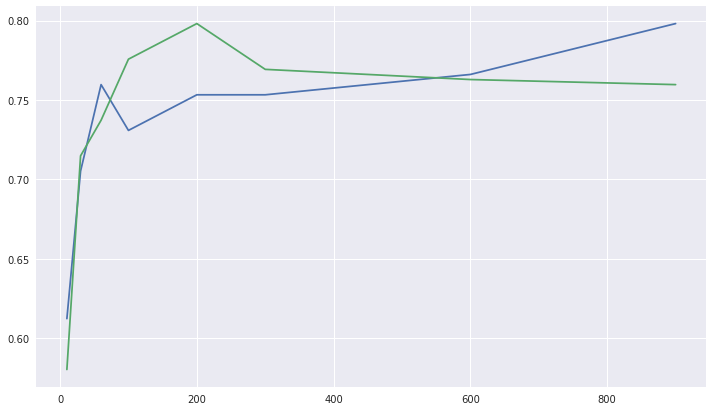

In [18]:
fig, ax = plt.subplots(figsize=(12, 7))
ax.plot(sizes, scores1)
ax.plot(sizes, scores2);

There is a good deal of randomness in ANN training but we can say that around 300
neurons (perceptrons) in the hidden layer we reached some form of plateau in accuracy
score.  The number of neurons in a layer is a hyperparameter and should be tuned
with a grid search.